# 8. 영화리뷰 텍스트 감성분석하기

## 8-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

### 라이브러리 버전을 확인해 봅니다

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import numpy as np
import tensorflow as tf
import os

### 1) 데이터 준비와 확인

In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


document와 해당하는 리뷰가 긍정인지(1) 부정인지(0)을 타나내는 label

In [5]:
# 훈련데이터 총 개수
len(train_data)

150000

In [6]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [7]:
# 테스트 데이터 총 개수
len(test_data)

50000

In [8]:
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')

In [9]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [10]:
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [11]:
train_data.shape

(149995, 3)

In [12]:
test_data.shape

(49997, 3)

### 2) 데이터로더 구성

데이터의 중복 제거

NaN 결측치 제거

한국어 토크나이저로 토큰화

불용어(Stopwords) 제거

사전word_to_index 구성

텍스트 스트링을 사전 인덱스 스트링으로 변환

X_train, y_train, X_test, y_test, word_to_index 리턴

In [13]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter


tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    '''
    train_data와 test_data 열의 중복 제거하기
    NaN 값 제거하기
    '''
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 

    
#     '''
#     정규화
#     '''
#     test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
#     test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
#     test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
#     test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
#     test_data = test_data.dropna(how='any') # Null 값 제거
#     print('전처리 후 테스트용 샘플의 개수 :',len(test_data))
    
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [14]:
len(X_train)

146182

In [15]:
len(X_test)

49157

In [16]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]


# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외


# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [17]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

In [18]:
sentences =[]
for sentence in train_data['document']:
    sentences.append(tokenizer.morphs(str(sentence)))
X_train = get_encoded_sentences(sentences, word_to_index)
X_train

[[1, 32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
 [1,
  1028,
  4,
  11,
  519,
  549,
  687,
  5,
  120,
  4,
  70,
  1639,
  52,
  925,
  1006,
  15,
  44,
  391],
 [1, 24, 205, 2],
 [1, 8409, 158, 3925, 4, 4, 298, 94, 2, 17, 6, 4, 4, 58, 3479],
 [1,
  2,
  2,
  8894,
  1108,
  52,
  2,
  2832,
  60,
  5,
  14,
  2758,
  41,
  1188,
  35,
  351,
  42,
  22,
  40,
  60,
  2,
  2,
  2,
  427,
  2,
  3102,
  1766,
  6],
 [1,
  675,
  2,
  2,
  131,
  420,
  185,
  1547,
  712,
  65,
  1694,
  715,
  53,
  375,
  192,
  271,
  5,
  4,
  69,
  4,
  11,
  2179,
  122,
  2,
  750,
  4],
 [1, 253, 2, 381, 9, 384, 2012, 55, 15, 817, 6, 4],
 [1,
  232,
  1450,
  2,
  144,
  6,
  425,
  756,
  2,
  2,
  52,
  1532,
  2,
  290,
  99,
  250,
  4,
  4,
  28,
  855,
  29,
  353,
  652,
  540,
  509,
  583,
  6,
  3318,
  4,
  8895,
  22,
  1460,
  1460,
  4,
  4,
  2,
  71,
  2,
  304,
  2,
  17,
  6,
  52,
  104,
  8,
  2,
  77,
  22,
  2,
  43],
 [1, 128, 2, 17, 23, 2, 94, 16, 2, 290, 27, 48, 2, 5]

In [19]:
len(train_data['document'])

146182

In [20]:
sentences =[]
for sentence in test_data['document']:
    sentences.append(tokenizer.morphs(str(sentence)))
X_test = get_encoded_sentences(sentences, word_to_index)
X_test

[[1, 832, 130],
 [1, 2],
 [1,
  85,
  111,
  2,
  58,
  2,
  2,
  4,
  70,
  950,
  332,
  44,
  38,
  100,
  37,
  641,
  2,
  3557,
  73,
  917],
 [1,
  96,
  8,
  15,
  2,
  44,
  231,
  137,
  357,
  129,
  4,
  11,
  153,
  54,
  7,
  10,
  42,
  2,
  2,
  4,
  70],
 [1,
  131,
  1114,
  22,
  73,
  21,
  459,
  232,
  2142,
  122,
  559,
  9,
  596,
  4,
  4,
  63,
  131,
  1114,
  29,
  635,
  346,
  2,
  2,
  844,
  8,
  12,
  8,
  295,
  18,
  18],
 [1, 237, 2, 54, 2, 160, 13, 56, 2, 237, 5],
 [1, 636, 2, 107],
 [1,
  1097,
  452,
  592,
  41,
  2,
  78,
  2,
  4917,
  1777,
  17,
  2,
  1545,
  4301,
  185,
  2,
  13,
  5722,
  2,
  2941,
  12,
  199],
 [1,
  563,
  1275,
  48,
  2,
  2,
  685,
  5,
  234,
  8,
  7,
  88,
  17,
  30,
  2994,
  493,
  6,
  126,
  123,
  51,
  2,
  27,
  48,
  2,
  2961,
  2,
  234,
  2,
  1209,
  2,
  32,
  1409,
  6,
  2,
  36,
  2,
  5,
  2,
  127,
  131,
  478,
  1577,
  318,
  2,
  6],
 [1,
  2974,
  2,
  1452,
  614,
  2,
  2,
  2,
  826,

In [21]:
X_test

[[1, 832, 130],
 [1, 2],
 [1,
  85,
  111,
  2,
  58,
  2,
  2,
  4,
  70,
  950,
  332,
  44,
  38,
  100,
  37,
  641,
  2,
  3557,
  73,
  917],
 [1,
  96,
  8,
  15,
  2,
  44,
  231,
  137,
  357,
  129,
  4,
  11,
  153,
  54,
  7,
  10,
  42,
  2,
  2,
  4,
  70],
 [1,
  131,
  1114,
  22,
  73,
  21,
  459,
  232,
  2142,
  122,
  559,
  9,
  596,
  4,
  4,
  63,
  131,
  1114,
  29,
  635,
  346,
  2,
  2,
  844,
  8,
  12,
  8,
  295,
  18,
  18],
 [1, 237, 2, 54, 2, 160, 13, 56, 2, 237, 5],
 [1, 636, 2, 107],
 [1,
  1097,
  452,
  592,
  41,
  2,
  78,
  2,
  4917,
  1777,
  17,
  2,
  1545,
  4301,
  185,
  2,
  13,
  5722,
  2,
  2941,
  12,
  199],
 [1,
  563,
  1275,
  48,
  2,
  2,
  685,
  5,
  234,
  8,
  7,
  88,
  17,
  30,
  2994,
  493,
  6,
  126,
  123,
  51,
  2,
  27,
  48,
  2,
  2961,
  2,
  234,
  2,
  1209,
  2,
  32,
  1409,
  6,
  2,
  36,
  2,
  5,
  2,
  127,
  131,
  478,
  1577,
  318,
  2,
  6],
 [1,
  2974,
  2,
  1452,
  614,
  2,
  2,
  2,
  826,

In [23]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [24]:
print(len(X_train))

146182


In [25]:
print(len(X_test))

49157


In [26]:
len(X_train[0])

11

In [27]:
X_train[0]

[1, 32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [29]:
len(X_train)

146182

In [31]:
len(X_test)

49157

### 3) 모델 구성을 위한 데이터 분석 및 가공

데이터셋 내 문장 길이 분포

적절한 최대 문장 길이 지정

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [32]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  19.72297390690031
문장길이 최대 :  117
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  50
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다. 


In [33]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)



X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train)
print(X_train.shape)
print(X_test)
print(X_test.shape)

[[   0    0    0 ...   20   33  748]
 [   0    0    0 ...   15   44  391]
 [   0    0    0 ...   24  205    2]
 ...
 [   0    0    0 ... 2710    6   18]
 [   0    0    0 ...    2    2 8572]
 [   0    0    0 ...    2 2740    5]]
(146182, 50)
[[   0    0    0 ...    1  832  130]
 [   0    0    0 ...    0    1    2]
 [   0    0    0 ... 3557   73  917]
 ...
 [   0    0    0 ...    8   12 3424]
 [   0    0    0 ...   67  323   43]
 [   0    0    0 ...  179   63 1058]]
(49157, 50)


### 4) 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요

In [34]:
# validation set 10000건 분리
x_val = X_train[:100000]   
y_val = y_train[:100000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 50)
(106182,)


### 5) 모델 훈련 개시

### 6) Loss, Accuracy 그래프 시각화

#### GlobalMaxPooling1D() ----------------------------------------------------------------------

In [35]:
vocab_size = 100000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 2  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 2)           200000    
_________________________________________________________________
global_max_pooling1d (Global (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 200,033
Trainable params: 200,033
Non-trainable params: 0
_________________________________________________________________


Sequential() : 
층을 구성하기위해 사용
.add()를 통해 층을 단계적으로 추가한다




tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))

첫번째 인자 = 단어 집합의 크기 즉 총 단어의 개수

두번째인자 = 임베딩 벡터의 출력 차원, 결과로서 나오는 임베딩 벡터의 크기

input_length = 입력 시퀀스의 길이

----

Dense

첫번째인자 : 출력 뉴런의 수

input_dim :  입력 뉴런의 수 (입력의 차원)

activation = 활성화함수


여기 설명 되게 잘 나와있음 
https://wikidocs.net/32105


In [36]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
208/208 [==============================] - 2s 5ms/step - loss: 0.6847 - accuracy: 0.6349 - val_loss: 0.6585 - val_accuracy: 0.7101
Epoch 2/30
208/208 [==============================] - 1s 4ms/step - loss: 0.5896 - accuracy: 0.7519 - val_loss: 0.5078 - val_accuracy: 0.7832
Epoch 3/30
208/208 [==============================] - 1s 4ms/step - loss: 0.4616 - accuracy: 0.8002 - val_loss: 0.4276 - val_accuracy: 0.8142
Epoch 4/30
208/208 [==============================] - 1s 4ms/step - loss: 0.4114 - accuracy: 0.8230 - val_loss: 0.4008 - val_accuracy: 0.8250
Epoch 5/30
208/208 [==============================] - 1s 4ms/step - loss: 0.3888 - accuracy: 0.8334 - val_loss: 0.3871 - val_accuracy: 0.8306
Epoch 6/30
208/208 [==============================] - 1s 4ms/step - loss: 0.3742 - accuracy: 0.8394 - val_loss: 0.3784 - val_accuracy: 0.8342
Epoch 7/30
208/208 [==============================] - 1s 4ms/step - loss: 0.3635 - accuracy: 0.8435 - val_loss: 0.3724 - val_accuracy: 0.8357
Epoch 

In [37]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4360 - accuracy: 0.8128
[0.435979962348938, 0.8127835392951965]


In [38]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


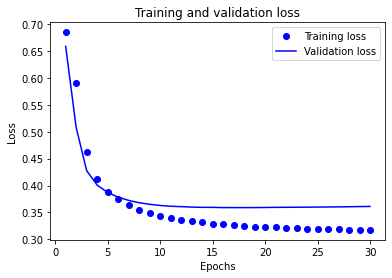

In [39]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

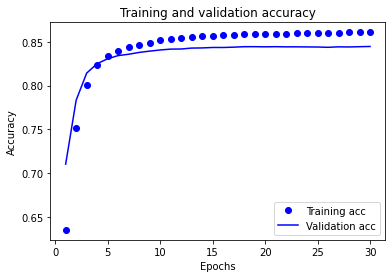

In [40]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### CNN -------------------------------------------------------------------------------------------------

In [41]:
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16 # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(5))
# model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
dense_2 (Dense)              (None, None, 8)           136       
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           9         
Total params: 161,953
Trainable params: 161,953
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
208/208 [==============================] - 4s 8ms/step - loss: 0.6597 - accuracy: 0.5700 - val_loss: 0.6291 - val_accuracy: 0.5935
Epoch 2/30
208/208 [==============================] - 1s 7ms/step - loss: 0.6271 - accuracy: 0.5918 - val_loss: 0.6239 - val_accuracy: 0.5961
Epoch 3/30
208/208 [==============================] - 1s 7ms/step - loss: 0.6228 - accuracy: 0.5947 - val_loss: 0.6237 - val_accuracy: 0.5920
Epoch 4/30
208/208 [==============================] - 1s 7ms/step - loss: 0.6204 - accuracy: 0.5964 - val_loss: 0.6220 - val_accuracy: 0.5932
Epoch 5/30
208/208 [==============================] - 1s 7ms/step - loss: 0.6189 - accuracy: 0.5973 - val_loss: 0.6199 - val_accuracy: 0.5976
Epoch 6/30
208/208 [==============================] - 1s 7ms/step - loss: 0.6171 - accuracy: 0.5986 - val_loss: 0.6186 - val_accuracy: 0.5978
Epoch 7/30
208/208 [==============================] - 1s 7ms/step - loss: 0.6157 - accuracy: 0.5969 - val_loss: 0.6183 - val_accuracy: 0.5983
Epoch 

In [43]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6396 - accuracy: 0.5858
[0.6396089196205139, 0.5858384370803833]


In [44]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


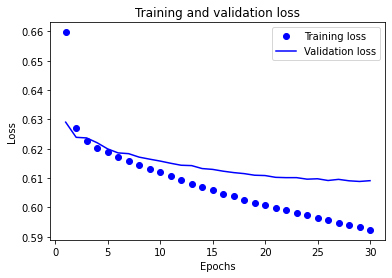

In [45]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

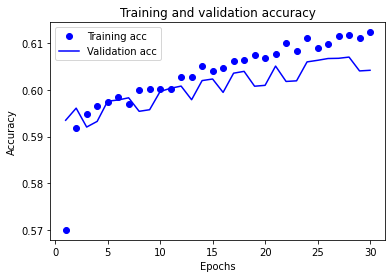

In [46]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### RNN ------------------------------------------------------------------------------------------------

In [49]:
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
tf.random.set_seed(3)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))   
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)



model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
830/830 [==============================] - 8s 8ms/step - loss: 0.3897 - accuracy: 0.8225 - val_loss: 0.3156 - val_accuracy: 0.8663
Epoch 2/10
830/830 [==============================] - 7s 8ms/step - loss: 0.3060 - accuracy: 0.8693 - val_loss: 0.2841 - val_accuracy: 0.8849
Epoch 3/10
830/830 [==============================] - 7s 8ms/step - loss: 0.2635 - accuracy: 0.8895 - val_loss: 0.2651 - val_accuracy: 0.8934
Epoch 4/10
830/830 [==============================] - 7s 8ms/step - loss: 0.2290 - accuracy: 0.9050 - val_loss: 0.2484 - val_accuracy: 0.9019
Epoch 5/10
830/830 [==============================] - 7s 8ms/step - loss: 0.1986 - accuracy: 0.9196 - val_loss: 0.2393 - val_accuracy: 0.9087
Epoch 6/10
830/830 [==============================] - 7s 8ms/step - loss: 0.1701 - accuracy: 0.9321 - val_loss: 0.2521 - val_accuracy: 0.9104
Epoch 7/10
830/830 [==============================] - 7s 8ms/step - loss: 0.1461 - accuracy: 0.9421 - val_loss: 0.2508 - val_accuracy: 0.9153
Epoch 

In [51]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6111 - accuracy: 0.8400
[0.6110930442810059, 0.8400431275367737]


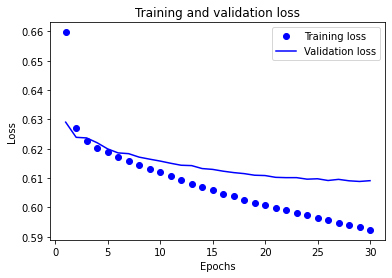

In [52]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

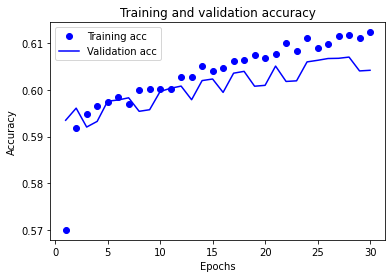

In [53]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Gensim

In [54]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word_vector_dim = 100
vocab_size = 9999
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2veccc.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]

for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [55]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('소울', 0.9009596109390259),
 ('로즈', 0.8873754143714905),
 ('강추', 0.8836604356765747),
 ('노홍철', 0.882411777973175),
 ('정책', 0.8804174065589905),
 ('집시', 0.8803420066833496),
 ('이동욱', 0.8790072798728943),
 ('수작', 0.8786147236824036),
 ('소주', 0.8770931959152222),
 ('번호', 0.8757091760635376)]

In [56]:
word_vectors.similar_by_word("영화")

[('준다', 0.601139485836029),
 ('정말로', 0.5771589875221252),
 ('는겨', 0.5496131181716919),
 ('잖아', 0.5039725303649902),
 ('께', 0.4962550103664398),
 ('ㅋㅋ', 0.4961957633495331),
 ('천국', 0.489361047744751),
 ('닷', 0.48892873525619507),
 ('니다', 0.48744913935661316),
 ('리쉬', 0.48635122179985046)]

#### 한국어 Word2Vec

In [57]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'


word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']

In [58]:
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [59]:
vector = word_vectors.wv['시작']
vector

array([-1.16053   ,  3.2086124 , -0.8464585 , -0.21354361,  5.7969356 ,
        0.18993846, -2.6679456 ,  5.1422763 ,  0.70769715,  0.67083716,
       -2.8080425 ,  1.1404599 , -1.367787  , -1.4466493 ,  7.5045366 ,
       -0.9983406 ,  1.5922157 ,  0.59020776,  6.3408074 ,  3.0450768 ,
       -2.4441054 ,  4.4043674 ,  1.6067554 , -4.8582635 ,  0.49741057,
        1.5097246 , -1.6164384 , -2.6722224 ,  1.9465922 ,  4.988424  ,
       -3.884758  ,  2.6203034 ,  3.2578673 ,  1.5888767 , -0.49142   ,
        1.0968636 , -3.5188727 ,  0.17855728,  3.7370596 , -2.685119  ,
        1.320543  , -1.9419105 ,  4.5419254 , -3.970305  ,  0.6959733 ,
       -4.1972575 ,  1.4016238 ,  2.9008312 ,  3.3938718 , -1.2880683 ,
       -1.4832399 , -1.1575463 , -3.10531   , -3.2233114 , -2.1278367 ,
       -4.0140653 , -2.222649  ,  0.9956357 ,  2.4712307 ,  0.32640433,
        0.904556  ,  4.7066073 , -1.6040367 ,  4.9517636 , -1.4919065 ,
       -0.08459547,  2.105639  , -4.060081  , -1.1459922 , -1.19

In [62]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

### 7) 학습된 Embedding 레이어 분석

In [70]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
tf.random.set_seed(2023)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(tf.keras.layers.LSTM(128))   
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)



model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))  # 80%만 돌리겠다는..
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.



model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,125,569
Trainable params: 1,125,569
Non-trainable params: 0
_________________________________________________________________


In [73]:
# 학습의 진행
opt= tf.keras.optimizers.Adam(learning_rate =0.0001)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=1 #  ((36)) 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

208/208 [==============================] - 5s 18ms/step - loss: 0.2186 - accuracy: 0.9130 - val_loss: 0.2673 - val_accuracy: 0.8940


epochs = 35를 실행했을떄, accuracy: 0.8499 가 나와서

1번더해줬다

In [74]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3645 - accuracy: 0.8511
[0.3645176291465759, 0.851089358329773]


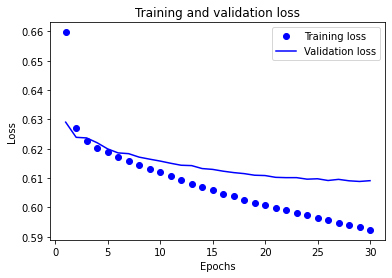

In [75]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

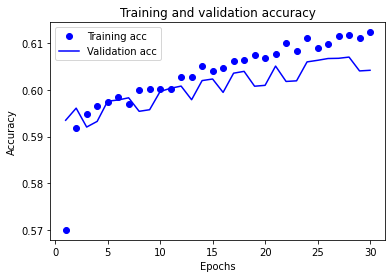

In [76]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [77]:
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [78]:
word_vectors.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

## 회고

1. 이번 프로젝트에서 **어려웠던 점,**
    
    단어장을 만들기 위해 처리하는 과정에서부터 어려움을 느꼈었다
    
    많은 과정에서 어려움이있었지만, 마지막에 X_train, X_test에서 크기가 1이 차이났었는데, 
    
    그 부분에서 해답을 찾는 과정이 힘들었다.
    
    
    
   

2. 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
    
    크기가 달랐던 이유는 load_data함수에서 train_data, test_data 가 지역변수로 설정되어있고 별다른 return을 하는게 아니여서였다.
    
    함수 실행전 dropna를 한번 실행해주고 실행하니 잘 돌아가는것을 확인할 수 있었다.

  


3. 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

    하이퍼파라미터값을 변경하며 85% 이상이 되도록 해보았다
    
    다양한 모델을 적용해보았고, gensim을 활용해 임베딩 레이어를 분석해보았다

4. 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.느낌

    모델을 돌려보는 과정에서 정확도가 85% 넘지 않는 부분이 마음에 걸리지만 모델을 성공적으로 돌려보기가 루브릭이기에 괜찮지 않을까 하는 마음이다
    

5. **자기 다짐**

    자연어 처리 프로젝트는 항상 힘들지만 이번 프로젝트는 단어장을 만들고 처리하는 과정이 힘들었다
    
    계속 헤매이던 부분인 크기맞추기에서 미처 생각지도 못한 부분에서 놓치고있어서 시간을 많이 쓰게되어 아쉬웠다
    
    이번 프로젝트를 진행하면서 놓쳤던 개념을 다시 알게되었고 다음번에는 이런일이 생긴다면 일찍 고려할 수 있지 않을까 하는 마음이다
    
    